### 1. Import Data & Python Packages

In [2]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [3]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("test.csv")

# preview train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 891.


In [5]:
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the test data is 418.


In [6]:
# preview test data
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### There is no target variable into test data (i.e. "Survival" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression.

### 2. Data Quality & Missing Value Assessment

In [7]:
# check missing values in train data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 2.1. Age - Missing Values

In [8]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 19.87%


~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general.

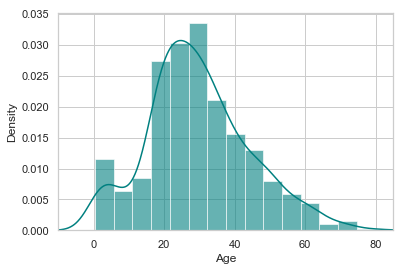

In [9]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values.

In [10]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))

# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


#### 2.2. Cabin - Missing Values

In [11]:
# percent of missing "Cabin" 

print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


77% of records are missing, which means that imputing information and using this variable for prediction is probably not wise. We'll ignore this variable in our model.

#### 2.3. Embarked - Missing Values

In [12]:
# percent of missing "Embarked" 

print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


There are only 2 (0.22% of 891 is 1.96) missing values for "Embarked", so we can just impute with the port where most people boarded.

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


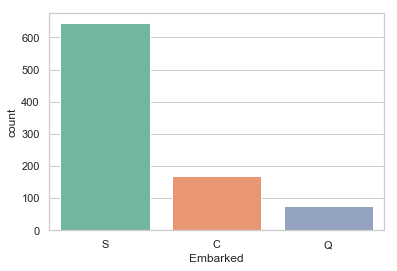

In [13]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

In [14]:
print('The most common boarding port of embarkation is %s.' %train_df['Embarked'].value_counts().idxmax())

The most common boarding port of embarkation is S.


As we can see from above graphs and data, the most passengers boarded in Southhampton, so we'll impute those 2 NaN's values in the train data with "S".

#### 2.4. Final Adjustments to Data (Train & Test)

Based on the assessment above of the missing values in the dataset, we will make the following changes to the data:

1. If "Age" is missing for a given row, we will impute with 28 (median age).

2. If "Embarked" is missing for a riven row, we will impute with "S" (the most common boarding port).

3. we will ignore "Cabin" as a variable. There are too many missing values for imputation. Based on the information available, it appears that this value is associated with the passenger's class and fare paid.

In [15]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [16]:
# check missing values in adjusted train data

train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [17]:
# preview adjusted train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


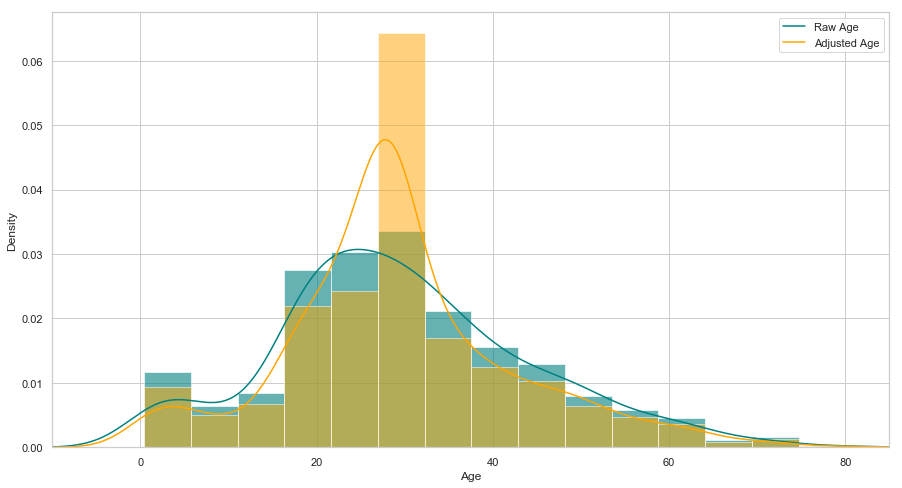

In [18]:
plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

#### 2.4.1. Additional Variables

According to the Kaggle data dictionary, both SibSp (# of siblings / spouses aboard the Titanic) and Parch (# of parents / children aboard the Titanic) relate to traveling with family. 

For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [19]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

##### I'll also create categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked").

In [20]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

In [21]:
final_train = training

In [22]:
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


##### Now, we will apply the same changes to the test data. 

1. We will apply to same imputation for "Age" in the Test data as I did for my Training data (if missing, Age = 28). 

2. We will also remove the "Cabin" variable from the test data, as I've decided not to include it in my analysis. 

3. There were no missing values in the "Embarked" port variable. 

4. We will add the dummy variables to finalize the test set. 

5. Finally, we will impute the 1 missing value for "Fare" with the median, 14.45.

In [23]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [24]:
test_data = test_df.copy()

test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)

test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)

test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)

test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])

testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

In [25]:
final_test = testing

In [26]:
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


### 3. Exploratory Data Analysis

#### 3.1. Exploration of Age

C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


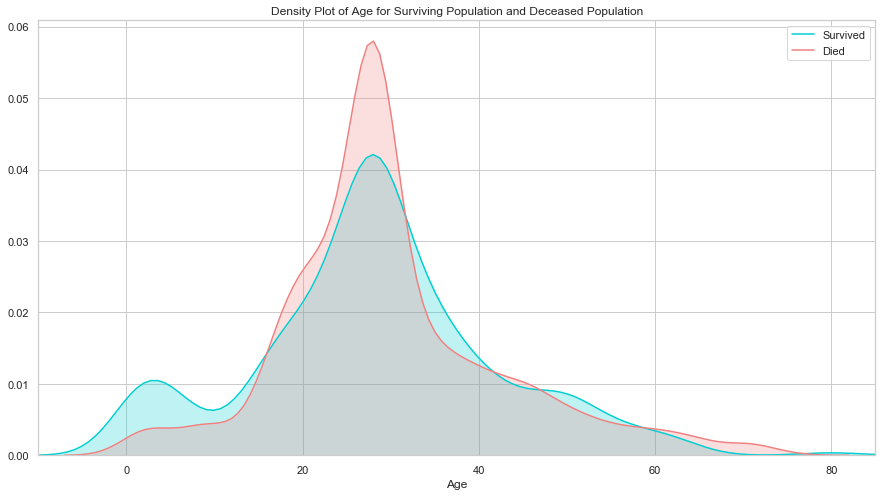

In [27]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)


plt.show()

The age distribution for survivors and deceased is actually very similar. One notable difference is that, of the survivors, a larger proportion were children. The passengers evidently made an attempt to save children by giving them a place on the life rafts.

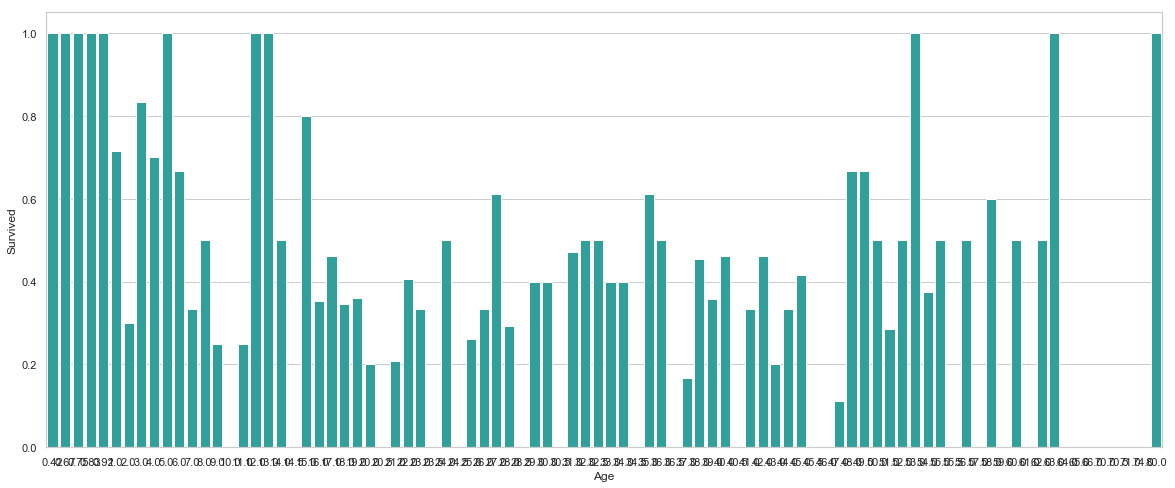

In [28]:
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")


plt.show()

Considering the survival rate of passengers under 16, we will also include another categorical variable in our train and test dataset: "Minor"

In [29]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

#### 3.2. Exploration of Fare

C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


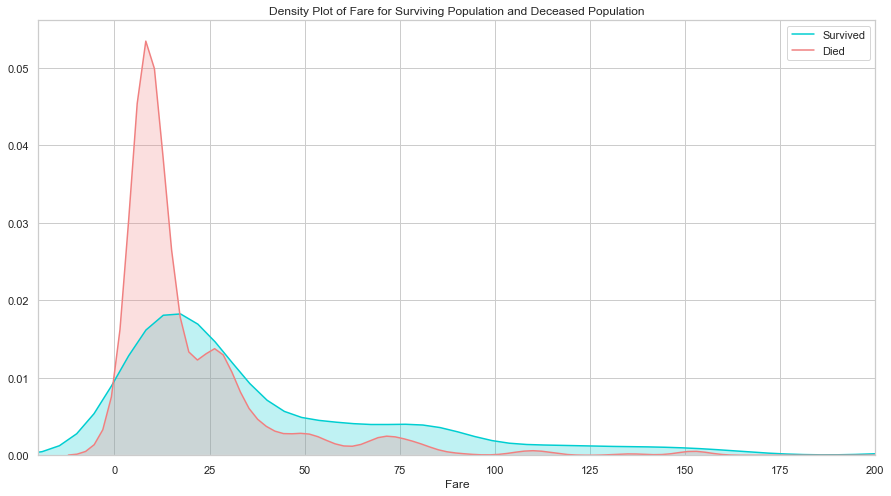

In [30]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)


plt.show()

As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model. Passengers who paid lower fare appear to have been less likely to survive. This is probably strongly correlated with Passenger Class, which we'll look at next.

#### 3.3. Exploration of Passenger Class

C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


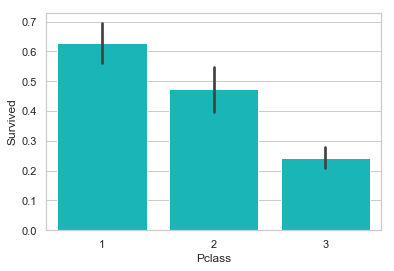

In [31]:
sns.barplot('Pclass', 'Survived', data=train_df, color="darkturquoise")

plt.show()

As expected, being a first class passenger was safest.

#### 3.4. Exploration of Embarked Port

C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


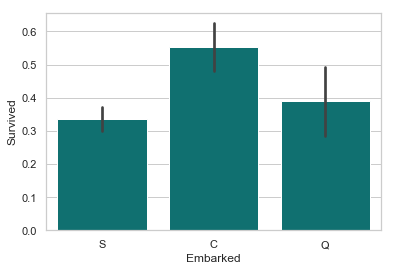

In [32]:
sns.barplot('Embarked', 'Survived', data=train_df, color="teal")

plt.show()

Passengers who boarded in Cherbourg, France, appear to have the highest survival rate. Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown. This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck). 

It's also worth noting the size of the whiskers in these plots. Because the number of passengers who boarded at Southhampton was highest, the confidence around the survival rate is the highest. The whisker of the Queenstown plot includes the Southhampton average, as well as the lower bound of its whisker. It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southhampton counterparts.

#### 3.5. Exploration of Traveling Alone vs. With Family

C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


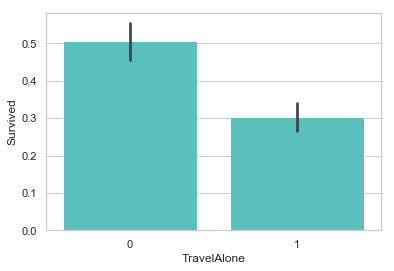

In [33]:
sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")

plt.show()

Individuals traveling without family were more likely to die in the disaster than those with family aboard. Given the era, it's likely that individuals traveling alone were likely male.

#### 3.6. Exploration of Gender Variable

C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


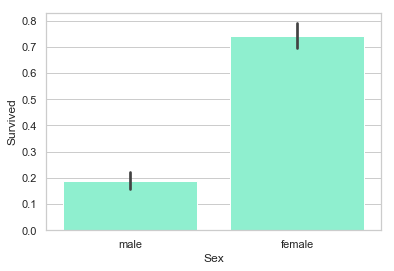

In [34]:
sns.barplot('Sex', 'Survived', data=train_df, color="aquamarine")

plt.show()

Clearly being female greatly increased your chances of survival.

### 4. Logistic Regression and Results

#### 4.1. Feature selection

#### 4.1.1. Recursive Feature Elimination

Given an external estimator that assigns weights to features, RECURSIVE FEATURE ELIMINATION (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

References: 
http://scikit-learn.org/stable/modules/feature_selection.html 

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']

In [36]:
# Build a logreg and compute the feature importances

model = LogisticRegression()

In [37]:
# create the RFE model and select 8 attributes

rfe = RFE(model, 8)
rfe = rfe.fit(X, y)

In [38]:
# summarize the selection of the attributes

print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


#### 4.1.2. Feature ranking with Recursive Feature Elimination and cross-validation (RFECV)

RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. Hereafter a recursive feature elimination applied on logistic regression with automatic tuning of the number of features selected with cross-validation.

In [39]:
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.

# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')

rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

Optimal number of features: 8
Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


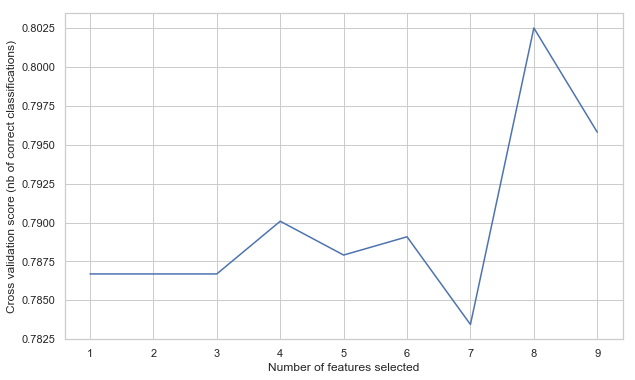

In [40]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

As we can see, 8 variables were kept in our model.

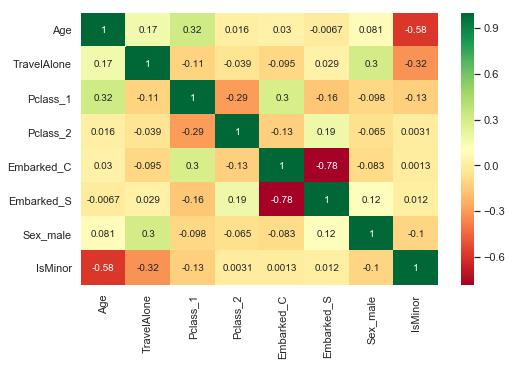

In [41]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

#### 4.2. Review of Model Evaluation procedures

Motivation: Need a way to choose between machine learning models

* Goal is to estimate likely performance of a model on out-of-sample data

Initial idea: Train and test on the same data

* But, maximizing training accuracy rewards overly complex models which overfit the training data

Alternative idea: Train/test split

* Split the dataset into two pieces, so that the model can be trained and tested on different data
* Testing accuracy is a better estimate than training accuracy of out-of-sample performance

Problem with train/test split

* It provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy
* Testing accuracy can change a lot depending on a which observation happen to be in the testing set


Reference: 
http://www.ritchieng.com/machine-learning-cross-validation/ 

#### 4.2.1. Model Evaluation based on simple train/test split using train_test_split() function

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)

X = final_train[Selected_features]
y = final_train['Survived']

In [43]:
# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [44]:
# check classification scores of logistic regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.839


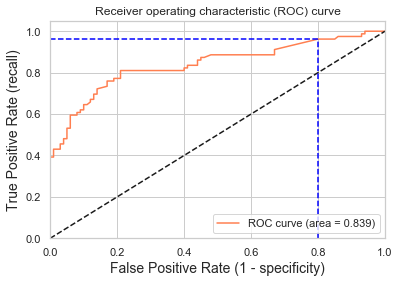

Using a threshold of 0.071 guarantees a sensitivity of 0.962 and a specificity of 0.200, i.e. a false positive rate of 80.00%.


In [45]:
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

#### 4.2.2. Model evaluation based on K-fold cross-validation using cross_val_score() function

In [46]:
# 10-fold cross-validation logistic regression

logreg = LogisticRegression()

# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.802
LogisticRegression average log_loss is 0.454
LogisticRegression average auc is 0.850


#### 4.2.3. Model evaluation based on K-fold cross-validation using cross_validate() function

In [47]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.802 (+/-0.025)
LogisticRegression average log_loss: 0.454 (+/-0.034)
LogisticRegression average auc: 0.850 (+/-0.025)


#### What happens when we add the feature "Fare"?

In [48]:
cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"]

X = final_train[cols]

In [49]:
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, final_train[cols], y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.796 (+/-0.028)
LogisticRegression average log_loss: 0.455 (+/-0.034)
LogisticRegression average auc: 0.849 (+/-0.025)


#### We notice that the model is slightly deteriorated. The "Fare" variable does not carry any useful information. Its presence is just a noise for the logistic regression model.

#### 4.3. GridSearchCV evaluating using multiple scorers simultaneously

In [50]:
from sklearn.model_selection import GridSearchCV

X = final_train[Selected_features]

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=2.8000100000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 2.8000100000000003}
best score: 0.8069584736251403


C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


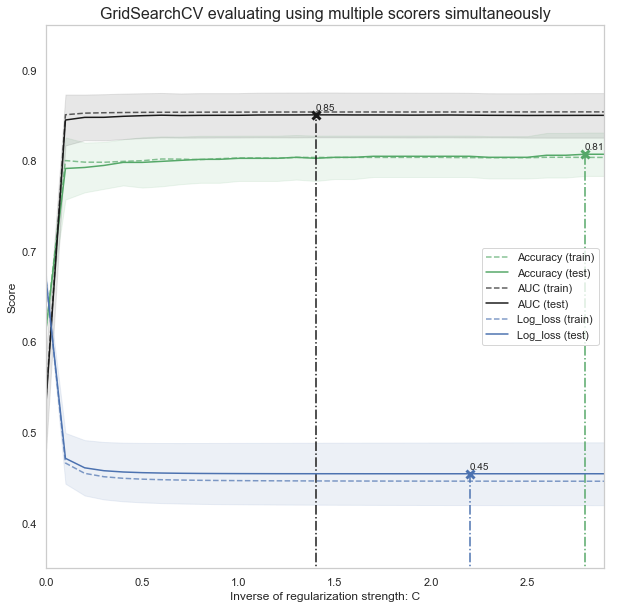

In [51]:
plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

#### 4.4. GridSearchCV evaluating using multiple scorers, RepeatedStratifiedKFold and pipeline for preprocessing simultaneously

We can applied many tasks together for more in-depth evaluation like gridsearch using cross-validation based on k-folds repeated many times, that can be scaled or no with respect to many scorers and tunning on parameter for a given estimator

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

#Define simple model

C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()

#Simple pre-processing estimators

std_scale = StandardScaler(with_mean=False, with_std=False)

#std_scale = StandardScaler()

#Defining the CV method: Using the Repeated Stratified K Fold

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)

#Creating simple pipeline and defining the gridsearch

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_

print('='*20)
print("best params: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
print('='*20)

best params: Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=False, with_std=False)), ('clf', LogisticRegression(C=5.00001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
best params: {'clf__C': 5.00001}
best score: 0.7966329966329966


C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\Nirmala Patel\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


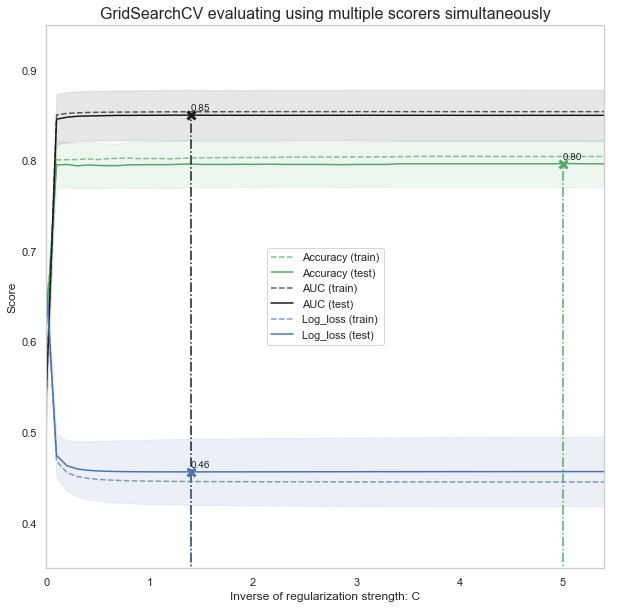

In [53]:
plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, C.max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray

X_axis = np.array(results['param_clf__C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [54]:
final_test['Survived'] = log_clf.predict(final_test[Selected_features])
final_test['PassengerId'] = test_df['PassengerId']

submission = final_test[['PassengerId','Survived']]

submission.to_csv("Final Prediction for Test set using LogReg.csv", index=False)

submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
